### Logistic regression models of $C_t$ given $\textbf{X}$.


In [1]:
from experiments.simulation import forward_simulation
from sklearn.linear_model import LogisticRegression
from hmm.types import FloatArray
from concurrent.futures import ThreadPoolExecutor

import seaborn as sns
import pandas as pd
import numpy as np

Simple function for getting simulated data as sample pairs $((C_1, ..., C_T), \textbf{X})$

In [2]:
def evaluate_logistic_regression_model(
    n: int,
    t: int,
    evaluation_T: int = 1000,
    iterations: int = 10,
    **kwargs
) -> list[float]:
    # Datas.
    evaluation_c = []
    evaluation_x = []
    for _ in range(1, 250):
        e_c, _, e_x = forward_simulation(n, t)
        evaluation_c.append(e_c[23])
        evaluation_x.append(e_x.flatten())

    accuracies = []

    with ThreadPoolExecutor() as executor:
        futures = []
        for _ in range(iterations):
            futures.append(executor.submit(run_iteration, n, t, evaluation_x, evaluation_c, kwargs))
        for future in futures:
            accuracies.append(future.result())

    return accuracies


def run_iteration(n, t, evaluation_x, evaluation_c, kwargs):
    c = []
    x = []
    for _ in range(1, 250):
        e_c, _, e_x = forward_simulation(n, t)
        c.append(e_c[23])
        x.append(e_x.flatten())
    # Fit log regression 
    clf = LogisticRegression(**kwargs, n_jobs=1).fit(x, c)
    return clf.score(evaluation_x, evaluation_c)

In [3]:
%%capture

timepoints = [*range(50, 1501, 50)]
accuracies_for_ts = [
    evaluate_logistic_regression_model(n=10, t=t)
        for t in timepoints
]

In [131]:
accuracies_for_ts

[[0.6565656565656566,
  0.6666666666666666,
  0.6161616161616161,
  0.5252525252525253,
  0.5353535353535354,
  0.6767676767676768,
  0.6868686868686869,
  0.5252525252525253,
  0.5757575757575758],
 [0.7070707070707071,
  0.6363636363636364,
  0.6363636363636364,
  0.5757575757575758,
  0.5858585858585859,
  0.6060606060606061,
  0.6161616161616161,
  0.6262626262626263,
  0.6060606060606061],
 [0.6161616161616161,
  0.6868686868686869,
  0.5959595959595959,
  0.5959595959595959,
  0.5858585858585859,
  0.696969696969697,
  0.5757575757575758,
  0.6464646464646465,
  0.6464646464646465],
 [0.6060606060606061,
  0.6464646464646465,
  0.6464646464646465,
  0.6161616161616161,
  0.6666666666666666,
  0.5252525252525253,
  0.6060606060606061,
  0.5858585858585859,
  0.6666666666666666],
 [0.6262626262626263,
  0.6060606060606061,
  0.5757575757575758,
  0.6363636363636364,
  0.6161616161616161,
  0.6262626262626263,
  0.696969696969697,
  0.5353535353535354,
  0.6363636363636364],
 [0.686

In [ ]:
df = pd.DataFrame(accuracies_for_ts).T
# Add column names to the DataFrame
df.columns = timepoints
df = df.melt(var_name='timepoint', value_name='accuracy')
df

,timepoint,accuracy
0,50,0.656566
1,50,0.666667
2,50,0.616162
3,50,0.525253
4,50,0.535354
...,...,...
85,500,0.595960
86,500,0.575758
87,500,0.616162
88,500,0.676768


/opt/homebrew/Caskroom/miniforge/base/envs/hmm/lib/python3.10/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  func(*plot_args, **plot_kwargs)


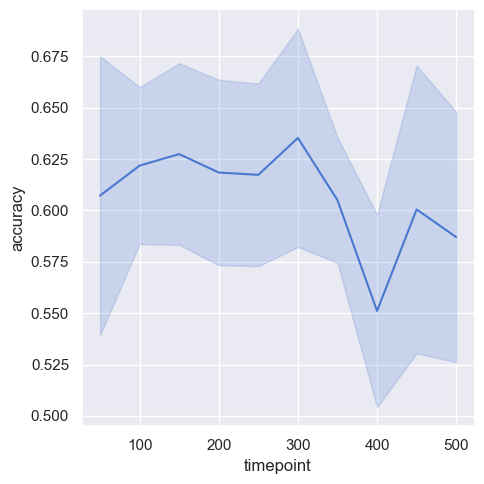

In [ ]:
# Plot the data using sns.relplot
sns.relplot(data=df, kind="line", x='timepoint', y='accuracy', ci="sd")
sns.set(style="darkgrid")
sns.set_palette("muted")

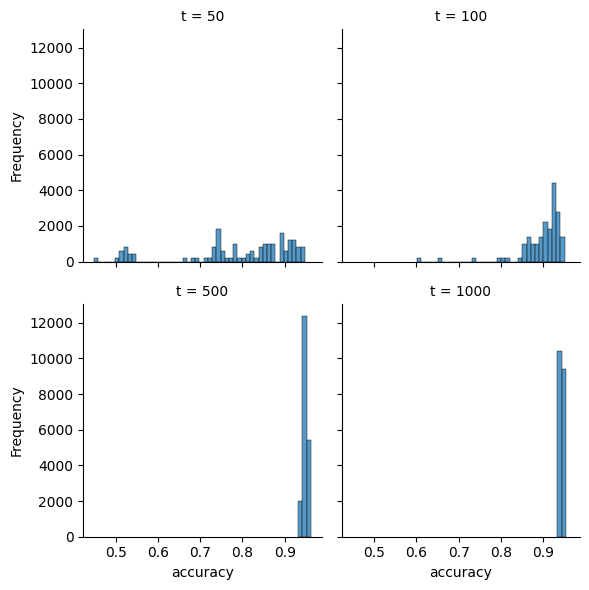

In [ ]:
# Create a FacetGrid with a separate subplot for each value of t
g = sns.FacetGrid(df.melt(var_name='t', value_name='accuracy'), col='t', col_wrap=2)
# Set the y-axis limit of each subplot to be between 0 and 1
for ax in g.axes.flat:
		# Add more xticks
		ax.set_xticks([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
		ax.set_xticklabels(['0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0'])
		ax.set(xlabel='Accuracy')	
g.map(sns.histplot, 'accuracy', binwidth=0.01, stat="frequency")